/opt/miniconda3/envs/analysis/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


0.9.3+199.g55a87fb
date
2017-12-02    0.091065
2017-12-03   -0.001972
Name: returns, dtype: float64
date
2024-12-13    0.006011
2024-12-14   -0.001195
2024-12-15    0.013959
2024-12-16    0.017503
2024-12-17   -0.001675
Name: returns, dtype: float64
              BTCUSD       cash
date                           
2017-11-29       0.0  100000.00
2017-11-30   97753.0    2051.49
2017-12-01   99070.5    2051.49
2017-12-02       0.0  110330.67
2017-12-03  108765.0    1348.14
                BTCUSD         cash
date                               
2024-12-13  53057620.0  25869735.71
2024-12-14  52963300.0  25869735.71
2024-12-15  54063700.0  25869735.71
2024-12-16  55462780.0  25869735.71
2024-12-17  55326540.0  25869735.71
BTCUSD    float64
cash      float64
dtype: object
           amount    price  symbol sid txn_dollars
date                                              
2017-11-30   10.0   9775.3  BTCUSD   0    -97753.0
2017-12-02  -10.0  10860.5  BTCUSD   0    108605.0
2017-12-03   10.0  1

开始日期,2017-11-29
结束日期,2024-12-17
总月数,84
,回测
年化收益率,156.99%
年化波动率,48.12%
夏普比率,2.20
Calmar 比率,3.83
Omega 比率,1.55
Sortino 比率,3.88
累计收益率,72796.25%


最差回撤期间,净回撤比率%,高点日期,低点日期,恢复日期,期间长度
0,40.95,2018-12-14,2019-06-26,2019-10-30,229
1,38.33,2021-06-21,2021-11-08,2022-01-22,155
2,34.81,2018-06-13,2018-07-24,2018-11-14,111
3,20.40,2024-06-05,2024-07-07,2024-09-10,70
4,20.25,2018-02-05,2018-03-05,2018-03-08,24


日收益率压力测试,mean,min,max
2018年下跌期,0.26%,-10.43%,11.63%


做多前10大仓位,最大
BTCUSD,100.17%


做空前10大仓位,最大
BTCUSD,-220.91%


前10大仓位,最大
BTCUSD,220.91%


transactions_create_round_trip_tear_sheet:             amount    price  symbol sid txn_dollars
date                                              
2017-11-30   10.0   9775.3  BTCUSD   0    -97753.0
2017-12-02  -10.0  10860.5  BTCUSD   0    108605.0
2017-12-03   10.0  10876.5  BTCUSD   0   -108765.0
2017-12-04  -10.0  11161.5  BTCUSD   0    111615.0
2017-12-05    9.0  11598.5  BTCUSD   0   -104386.5
positions_check_intraday:                BTCUSD       cash
date                           
2017-11-29       0.0  100000.00
2017-11-30   97753.0    2051.49
2017-12-01   99070.5    2051.49
2017-12-02       0.0  110330.67
2017-12-03  108765.0    1348.14
transactions_add_closing_transactions:             amount    price  symbol sid txn_dollars
date                                              
2017-11-30   10.0   9775.3  BTCUSD   0    -97753.0
2017-12-02  -10.0  10860.5  BTCUSD   0    108605.0
2017-12-03   10.0  10876.5  BTCUSD   0   -108765.0
2017-12-04  -10.0  11161.5  BTCUSD   0    111615.0
20

KeyError: 'close_dt'

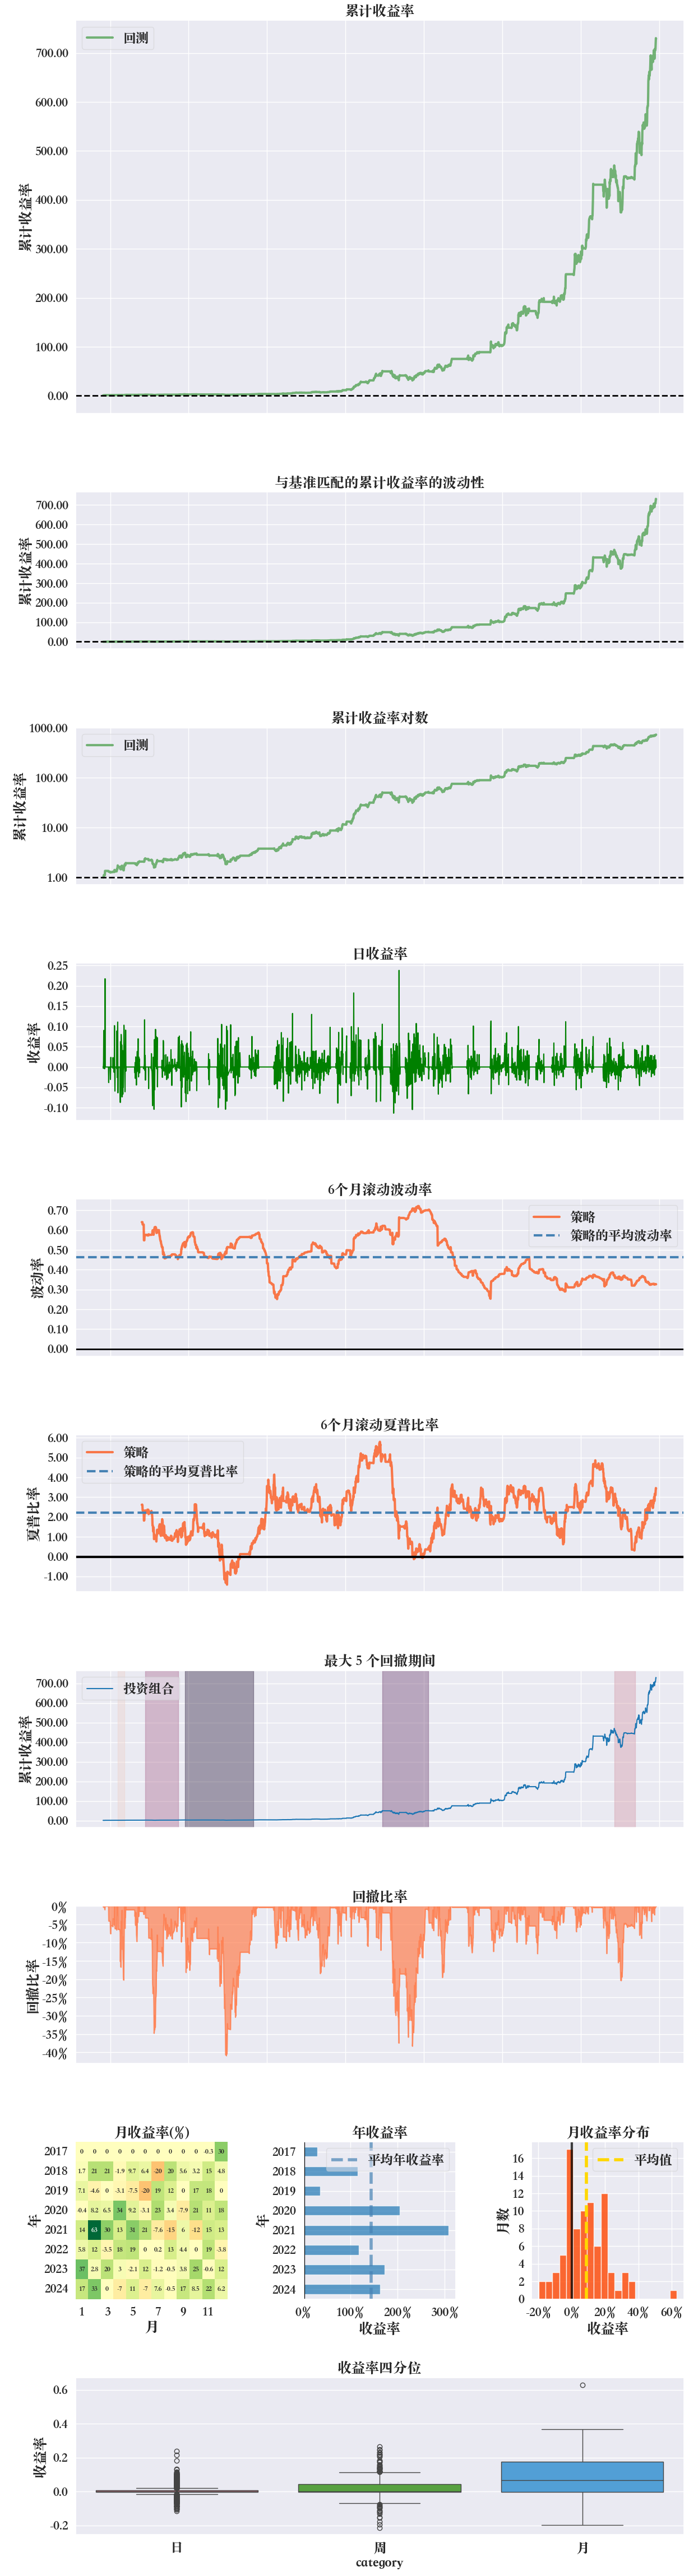

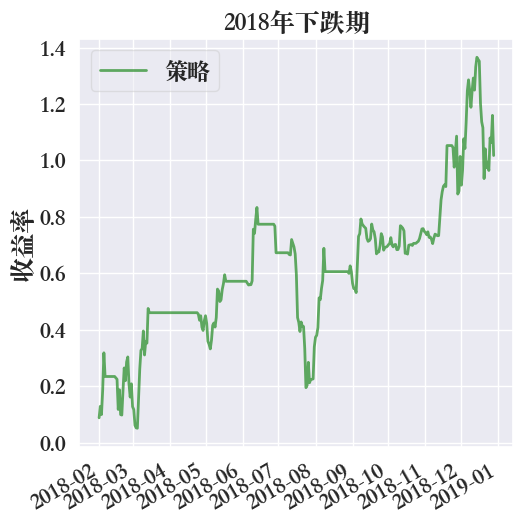

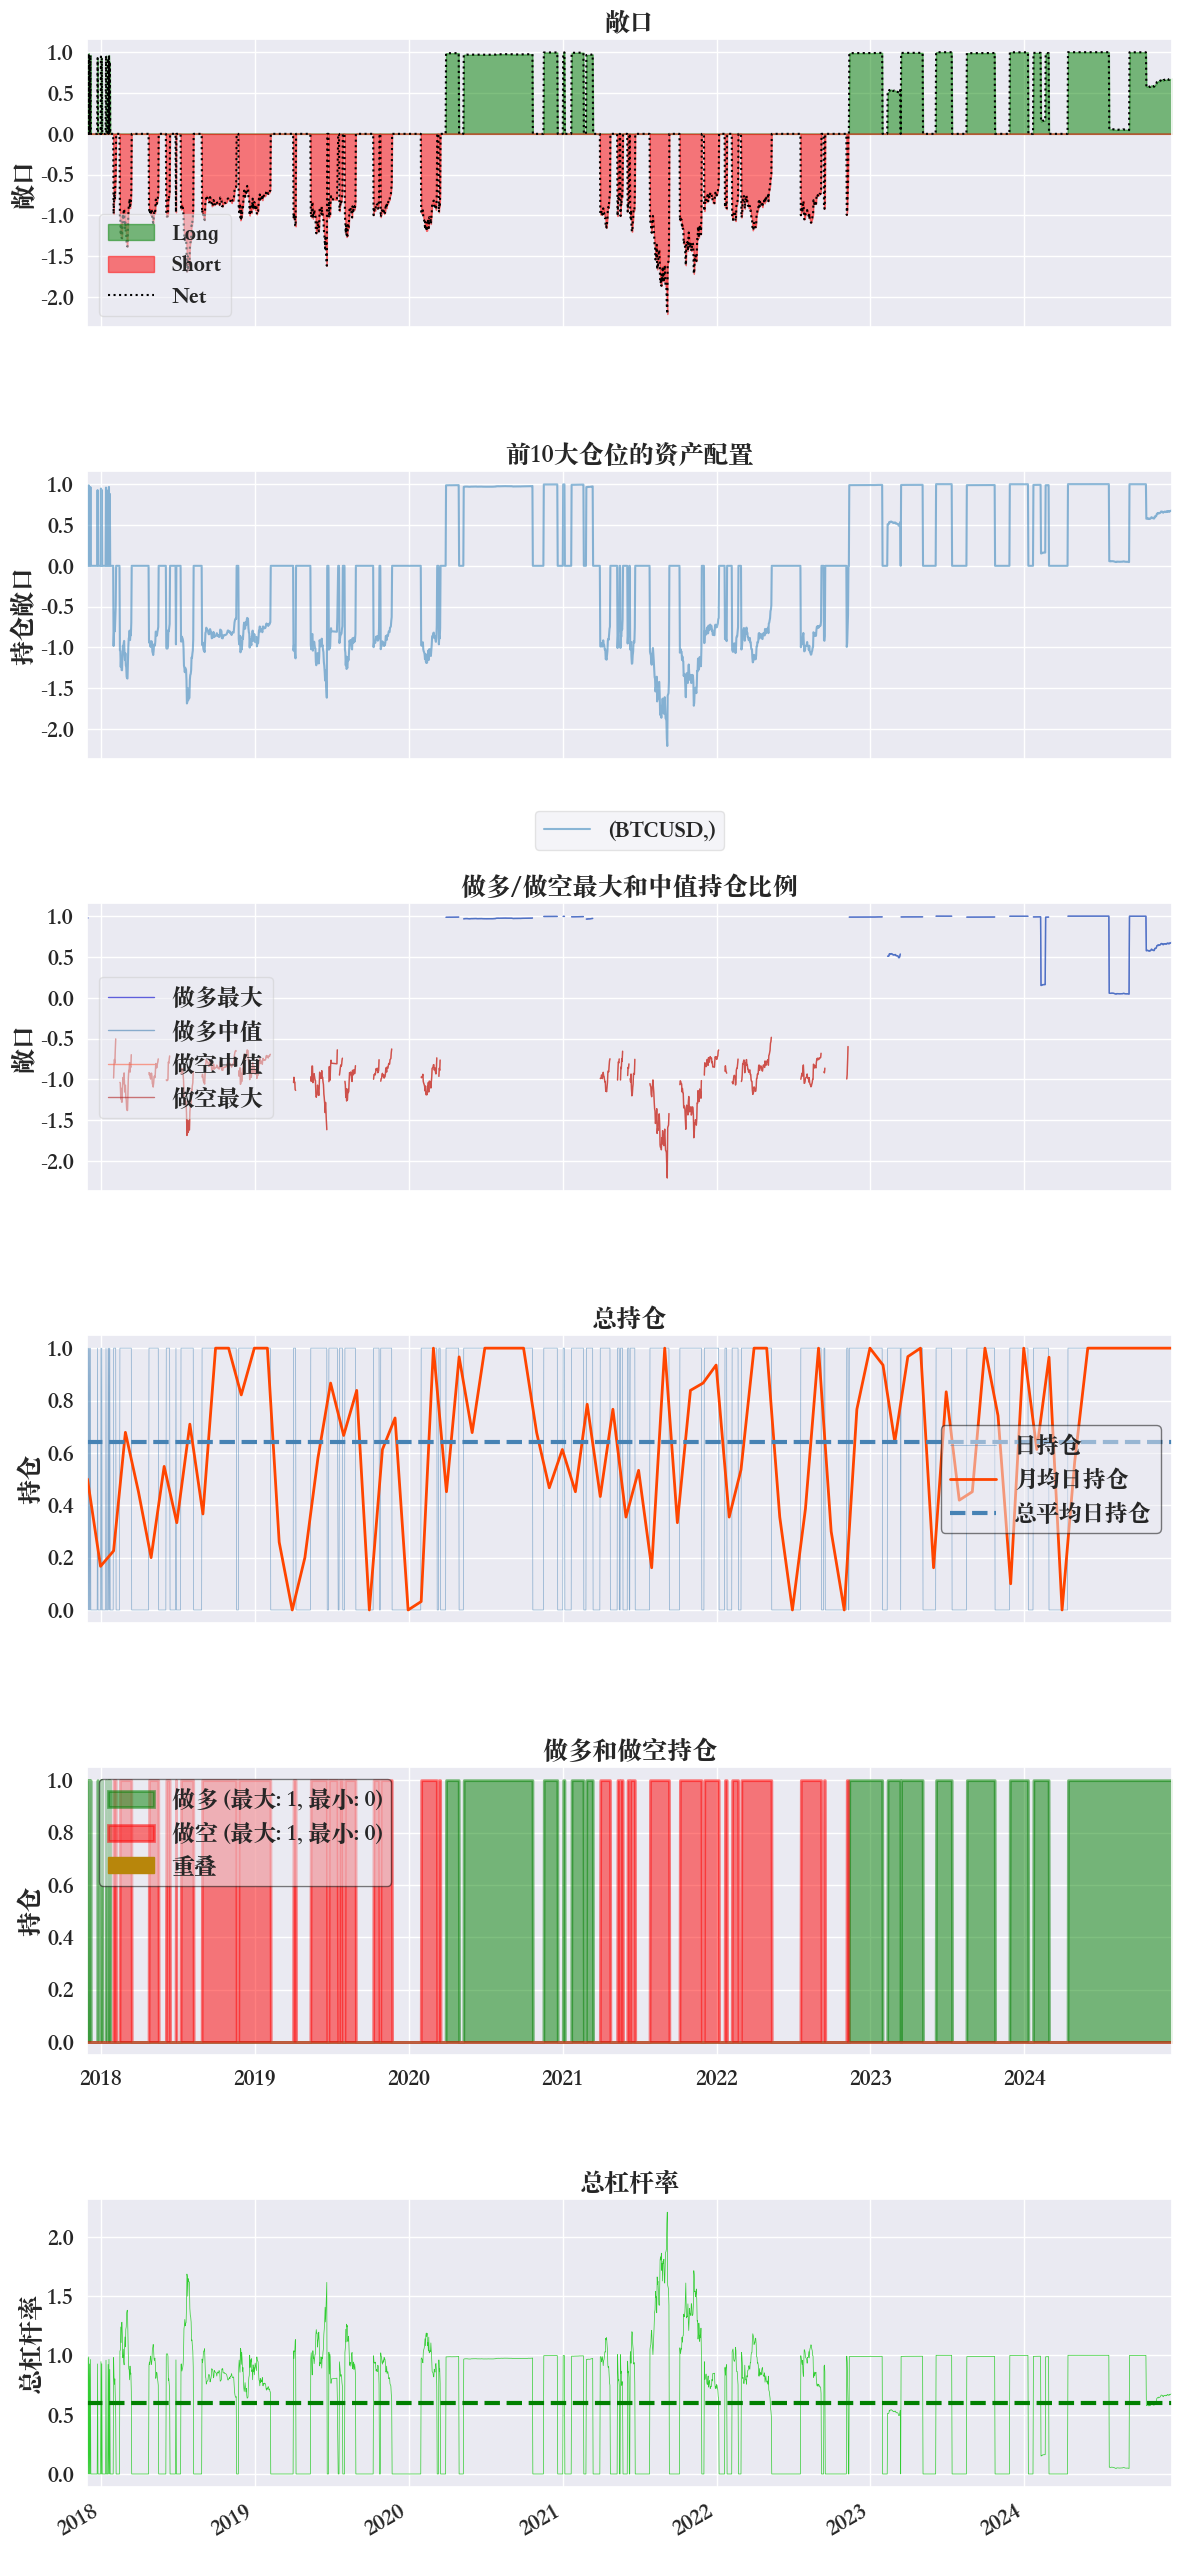

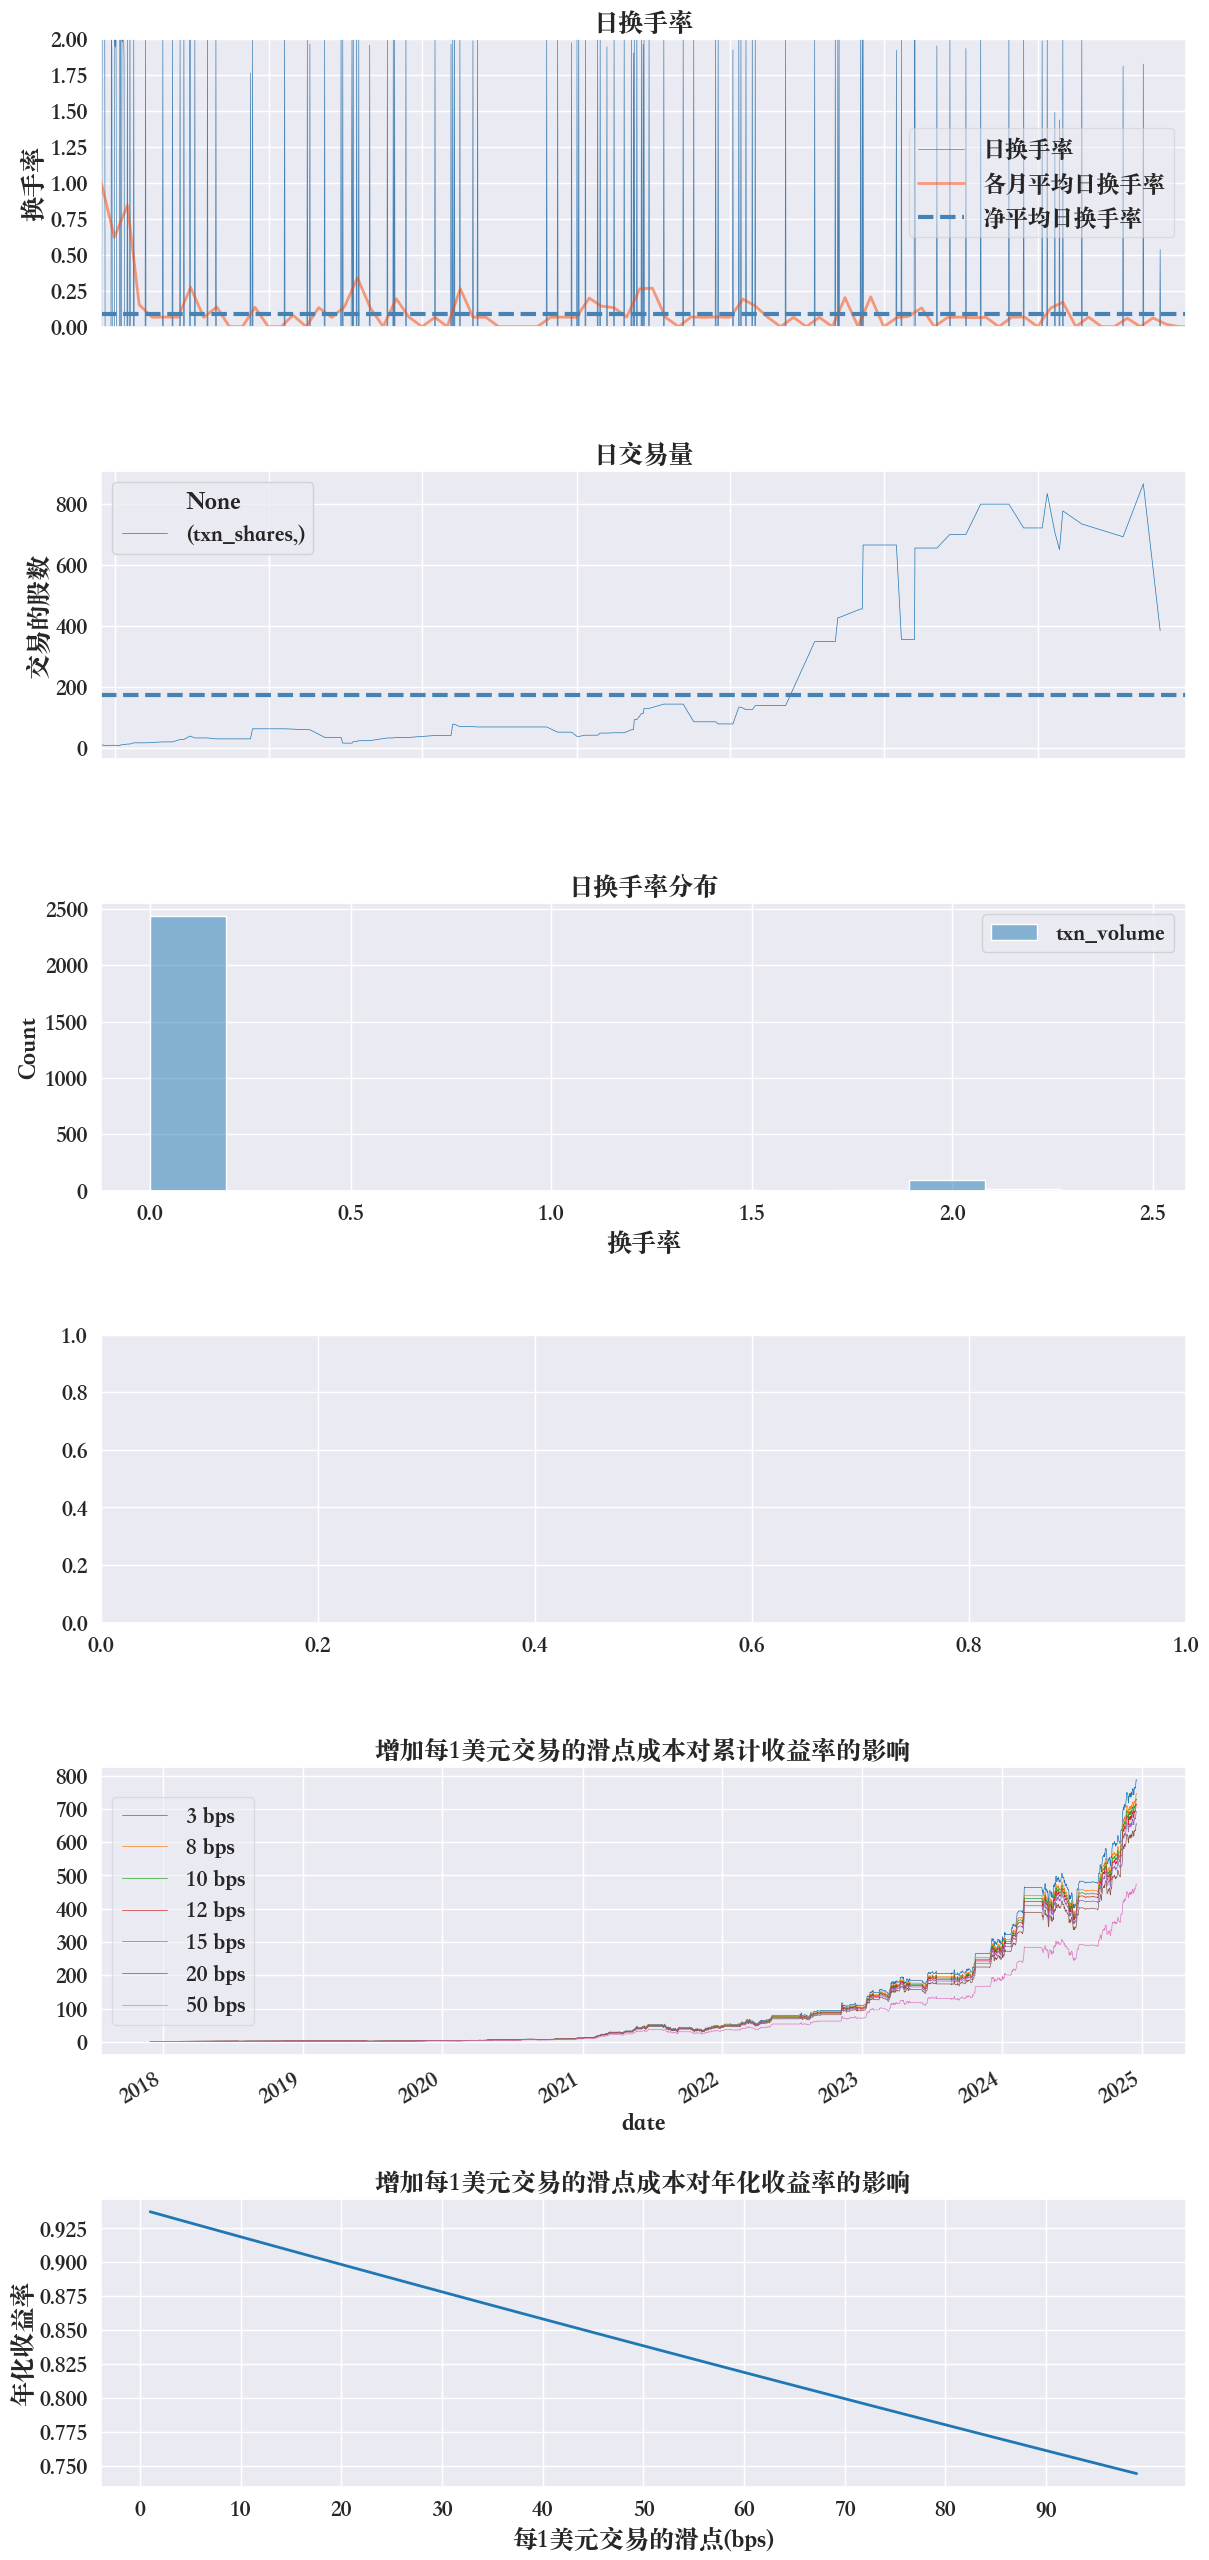

In [1]:
# %%

import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
bitcoin_strategy_backtest = pd.read_csv('bitcoin_strategy_backtest.csv', index_col=0, parse_dates=True)
returns = bitcoin_strategy_backtest['returns']
# print(returns.head())
print(pf.__version__)
#plt.show()

bitcoin_strategy_backtest['positions'] = bitcoin_strategy_backtest['positions'].apply(lambda x: x.replace("'", '"'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace("'", '"'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace("datetime.", '"datetime.'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace(")", ')"'))
positions = bitcoin_strategy_backtest[['positions', 'ending_cash']]
position_data = json.loads(positions.iloc[1, 0])
symbol = position_data[0]['symbol']
positions_edited = pd.DataFrame(0, index = positions.index, columns = [[symbol, 'cash']])
for index, row in positions.iterrows():
    position_data = json.loads(row['positions'])
    if position_data:
        positions_edited.loc[index, symbol] = position_data[0]['market_value']   
    positions_edited.loc[index, 'cash'] = float(row['ending_cash'])
#print(positions_edited.head()) 

transactions = bitcoin_strategy_backtest['transactions']
transactions_edited = pd.DataFrame(np.nan, index = transactions.index, columns = [['amount', 'price', 'symbol', 'sid', 'txn_dollars']])
transactions_edited['symbol'] = transactions_edited['symbol'].astype(str)
transactions_edited['sid'] = 0
for key, value in transactions.items():
    transactions_data = json.loads(value)
    if transactions_data:
        transactions_edited.loc[key, 'price'] = float(transactions_data[0]['price'])   
        transactions_edited.loc[key, 'amount'] = int(transactions_data[0]['amount'])
        transactions_edited.loc[key, 'symbol'] = symbol
        transactions_edited.loc[key, 'txn_dollars'] = - float(transactions_data[0]['price']) * int(transactions_data[0]['amount'])
transactions_edited = transactions_edited.dropna()
print(returns.head())
print(returns.tail())
print(positions_edited.head())
print(positions_edited.tail())
print(positions_edited.dtypes)
print(transactions_edited.head())
print(transactions_edited.tail())
print(transactions_edited.dtypes)
# pf.create_returns_tear_sheet(returns,
#                          positions=positions_edited,
#                          transactions=transactions_edited)
#                          slippage=1)
# help(pf.create_full_tear_sheet)
pf.create_full_tear_sheet(returns,
                        positions=positions_edited,
                        transactions=transactions_edited,
                        round_trips=True,
                        bootstrap=False,
                        estimate_intraday=False,
                        slippage=10)
plt.show()